# Infer ***cytoplasm***, ***nucleus***, and ***cell mask*** - 1️⃣ 2️⃣ 3️⃣

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #1 ***cytoplasm***, #2 ***nucleus***, and #3 ***cell mask***  in order to understand the organelle interactome 

Infer a segmentation of the ***cytoplasm***, ***nucleus***, and ***cell mask*** in order to measure their shape, position, size, and interaction with other organelles/cellular components.  

## OVERVIEW:

This combined methods developed in [01a_infer_cytoplasm_fromaggr.ipynb](./01a_infer_cytoplasm_fromaggr.ipynb) and [01b_infer_nucleus_cellmask_from_cytoplasm.ipynb](./01b_infer_nucleus_cellmask_from_cytoplasm.ipynb).

We will infer the cytoplasm using an weighted aggregate of multiple organelle channels, then use the cytoplasm mask to generate the nucleus and cell masks.



### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from aicssegmentation.core.pre_processing_utils import  intensity_normalization, image_smoothing_gaussian_slice_by_slice 
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label
import skimage


# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc_2d.core.img import *
import infer_subc_2d.organelles
       

%load_ext autoreload
%autoreload 2


## SETUP
CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

#### Get and load an image - specifically for __multichannel "raw"__ images

In [ ]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
# CUSTOMIZE HERE --->
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

# linearly unmixed ".czi" files are here
# CUSTOMIZE HERE --->
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files in "raw"
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [ ]:
# isolate image as an ndarray and metadata as a dictionary
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


### Get and load Image for processing - specifically for __pre-processed__ images

> #### Preprocessing:
> In this instance, we are using [Huygens Essential Software](https://svi.nl/Homepage) to deconvolve 3D fluorescence confocal images. The output is an OME TIFF file which contains the z-slices and channels in axis 0 (channel 0, zslice 1-40, channel 1, etc. etc.).

An OME TIFF reads in as a dask array (similar to a numpy array, but has a slightly different format)

In [2]:
# this will be the example for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents\Python Scripts\Infer-subc-2D"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

# get the list of all files in "raw"
img_file_list = list_image_files(data_path,im_type)
# test_img_name = img_file_list[test_img_n]
# test_img_name

img_file_list

['C:\\Users\\Shannon\\Documents\\Python Scripts\\Infer-subc-2D\\neuron_raw_OME\\20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome.tiff']

In [3]:
#select one image
test_img = img_file_list[0]

# isolate image as an ndarray and metadata as a dictionary
img_data, meta_dict = read_czi_image(test_img)

# # get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
huygens_meta = meta_dict['metadata']['raw_image_metadata']

c:\Users\Shannon\Anaconda3\envs\infer-subc-2D\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## infer ***cytoplasm***, ***nucleus***, and ***cell*** from data without nuclei marker


### INPUT

Get the "raw" signals we need to analyze as well as any other dependencies in "inferred" objects.  

In [4]:
###################
# INPUT
###################
weights = [0,4,1,1,2,2]

cyto_composite = make_aggregate(img_data, 
                                weights[0], 
                                weights[1], 
                                weights[2], 
                                weights[3], 
                                weights[4], 
                                weights[5],
                                scale_min_max=False) #channel order: LD, ER, golgi, lyso, mito, perox

weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


### PRE-PROCESSING

In [5]:
###################
# PRE_PROCESSING
###################  
cyto_struct_img = log_rescale_wrapper(cyto_composite)

### CORE PROCESSING

In [7]:
###################
# CORE_PROCESSING
###################
cyto_thresh_method = 'ave'
cyto_th_cutoff_sz = 50
cyto_th_adjust = 0.05
cyto_hole_min = 0
cyto_hole_max = 30
cyto_smallobj_max = 10
cyto_slice_or_3D = '3D'
cyto_connectivity = 1
cyto_cleaned_img = infer_subc_2d.organelles.cytoplasm.infer_cytoplasm_fromaggr(cyto_struct_img,
                                                                                    th_method=cyto_thresh_method,
                                                                                    th_cutoff_sz=cyto_th_cutoff_sz,
                                                                                    th_adjust=cyto_th_adjust,
                                                                                    smallhole_min_sz=cyto_hole_min,
                                                                                    smallhole_max_sz=cyto_hole_max,
                                                                                    smallobj_max_sz=cyto_smallobj_max,
                                                                                    slices_or_3D=cyto_slice_or_3D,
                                                                                    filter_connectivity=cyto_connectivity)

### POST PROCESSING

In [8]:
###################
# POST_PROCESSING
###################
nucleus_min_sz = 0
nucleus_max_sz = 500
nucleus_fill_2D = False

nucmask_holefill_min = 0
nucmask_holefill_max = 0
nucmask_small_object_width = 20
nucmask_method = '3D'
nucmask_connectivity = 3
cell_cleaned_img, nucleus_cleaned_img = infer_subc_2d.organelles.nuclei.infer_nucleus_cellmask_from_cytoplasm(cyto_cleaned_img,
                                                                                                                nucleus_min_sz= nucleus_min_sz,
                                                                                                                nucleus_max_sz= nucleus_max_sz,
                                                                                                                nucleus_fill_2D= nucleus_fill_2D,
                                                                                                                nucmask_holefill_min= nucmask_holefill_min,
                                                                                                                nucmask_holefill_max= nucmask_holefill_max, 
                                                                                                                nucmask_small_object_width= nucmask_small_object_width,
                                                                                                                nucmask_method= nucmask_method,
                                                                                                                nucmask_connectivity= nucmask_connectivity)


### RENAMING

In [9]:
###################
# RENAMING
###################
cytoplasm_mask = cyto_cleaned_img.astype(dtype=int)
cell_mask = cell_cleaned_img.astype(dtype=int)
nucleus_mask = nucleus_cleaned_img.astype(dtype=int)

## Visualize 1

In [10]:
viewer = napari.Viewer()

In [11]:
viewer.add_image(img_data, scale=scale)
viewer.add_image(cyto_composite, scale=scale)
viewer.add_image(cell_mask, scale=scale, opacity=0.25, colormap='gray')
viewer.add_image(cytoplasm_mask, scale=scale, opacity=0.25, colormap='bop orange')
viewer.add_image(nucleus_mask, scale=scale, opacity=0.25, colormap='blue')

<Image layer 'nucleus_mask' at 0x27455b3ae20>

In [12]:
viewer.close()

## DEFINE `_infer_cytoplasm_from_composite` function

Based on the _prototyping_ above define the function to infer nuclei.  


In [13]:
##########################
#  _infer_cyto_nuc_cellmask_fromaggr
##########################
def _infer_cyto_nuc_cellmask_fromaggr(in_img: np.ndarray,
                                        weights: list,
                                        cyto_thresh_method: str,
                                        cyto_th_cutoff_sz: int,
                                        cyto_th_adjust: int,
                                        cyto_hole_min: int,
                                        cyto_hole_max: int,
                                        cyto_smallobj_max: int,
                                        cyto_slice_or_3D: str,
                                        cyto_connectivity: int,
                                        nucleus_min_sz: int, 
                                        nucleus_max_sz: int, 
                                        nucleus_fill_2D: bool,
                                        nucmask_holefill_min: int,
                                        nucmask_holefill_max: int,
                                        nucmask_small_object_width: int,
                                        nucmask_method: str,
                                        nucmask_connectivity: int
                                        ) -> np.ndarray:
    """
    Procedure to infer 3D cytoplasm (cell area without the nucleus) segmentation from multichannel z-stack input.
    This can be used when segmenting the cytoplasm from a stain that fills the cytoplasm, but not the nuclear area.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    weights: list
        a list of weights for each channel in the image to create a merged image; 
        set to 0 if the channel should not be used

        
        
    Returns
    -------------
    cytoplasm_mask
        mask defined extent of cytoplasm (cell without the nuclear area)
    
    """

    ###################
    # INPUT
    ###################
    composite = make_aggregate(in_img, w0=weights[0], w1=weights[1], w2=weights[2], w3=weights[3], w4=weights[4], w5=weights[5], scale_min_max=False)

    ###################
    # PRE_PROCESSING
    ###################           
    struct_img = log_rescale_wrapper(composite)

    ###################
    # CORE_PROCESSING
    ###################
    cyto_cleaned_img = infer_subc_2d.organelles.cytoplasm.infer_cytoplasm_fromaggr(struct_img,
                                                                                    th_method=cyto_thresh_method,
                                                                                    th_cutoff_sz=cyto_th_cutoff_sz,
                                                                                    th_adjust=cyto_th_adjust,
                                                                                    smallhole_min_sz=cyto_hole_min,
                                                                                    smallhole_max_sz=cyto_hole_max,
                                                                                    smallobj_max_sz=cyto_smallobj_max,
                                                                                    slices_or_3D=cyto_slice_or_3D,
                                                                                    filter_connectivity=cyto_connectivity)

    ###################
    # POST_PROCESSING
    ###################
    cell_cleaned_img, nuc_cleaned_img = infer_subc_2d.organelles.nuclei.infer_nucleus_cellmask_from_cytoplasm(cyto_cleaned_img,
                                                                                                                  nucleus_min_sz= nucleus_min_sz,
                                                                                                                  nucleus_max_sz= nucleus_max_sz,
                                                                                                                  nucleus_fill_2D= nucleus_fill_2D,
                                                                                                                  nucmask_holefill_min= nucmask_holefill_min,
                                                                                                                  nucmask_holefill_max= nucmask_holefill_max, 
                                                                                                                  nucmask_small_object_width= nucmask_small_object_width,
                                                                                                                  nucmask_method= nucmask_method,
                                                                                                                  nucmask_connectivity= nucmask_connectivity)

    ###################
    # RENAMING
    ###################
    cytoplasm_mask = cyto_cleaned_img.astype(dtype=int)
    cell_mask = cell_cleaned_img.astype(dtype=int)
    nucleus_mask = nuc_cleaned_img.astype(dtype=int)

    return cytoplasm_mask, cell_mask, nucleus_mask

## DEFINE `_fixed_infer_cytoplasm_from_composite` function


In [16]:
##########################
#  fixed_infer_cytoplasm_from_composite
##########################
def _fixed_infer_cyto_nuc_cellmask_fromaggr(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    weights = [0,4,1,1,2,2]

    cyto_thresh_method = 'ave'
    cyto_th_cutoff_sz = 50
    cyto_th_adjust = 0.05
    cyto_hole_min = 0
    cyto_hole_max = 30
    cyto_smallobj_max = 10
    cyto_slice_or_3D = '3D'
    cyto_connectivity = 1

    nucleus_min_sz = 0
    nucleus_max_sz = 500
    nucleus_fill_2D = False

    nucmask_holefill_min = 0
    nucmask_holefill_max = 0
    nucmask_small_object_width = 20
    nucmask_method = '3D'
    nucmask_connectivity = 3


    return _infer_cyto_nuc_cellmask_fromaggr(in_img,
                                        weights,
                                        cyto_thresh_method,
                                        cyto_th_cutoff_sz,
                                        cyto_th_adjust,
                                        cyto_hole_min,
                                        cyto_hole_max,
                                        cyto_smallobj_max,
                                        cyto_slice_or_3D,
                                        cyto_connectivity,
                                        nucleus_min_sz, 
                                        nucleus_max_sz, 
                                        nucleus_fill_2D,
                                        nucmask_holefill_min,
                                        nucmask_holefill_max,
                                        nucmask_small_object_width,
                                        nucmask_method,
                                        nucmask_connectivity)


---------------------
## TEST `_infer_cyto_nuc_cell_from_composite` function defined above


In [17]:
_cytoplasm_mask, _cell_mask, _nuc_mask =  _fixed_infer_cyto_nuc_cellmask_fromaggr(img_data)

weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


In [18]:
viewer = napari.Viewer()

In [19]:
viewer.add_image(img_data, scale=scale)
viewer.add_image(cyto_composite, scale=scale)
viewer.add_image(_cytoplasm_mask, scale=scale, opacity=0.25, colormap='bop orange')
viewer.add_image(_cell_mask, scale=scale, opacity=0.25, colormap='gray')
viewer.add_image(_nuc_mask, scale=scale, opacity=0.25, colormap='blue')

<Image layer '_nuc_mask' at 0x27455658c40>

In [20]:
viewer.close()

---------------------
# TEST `infer_cytoplasm_from_composite` exported functions

> the prototype `_infer_cyto_nuc_cellmask_fromaggr` was copied to the [`.organelles.cellmask`](../infer_subc_2d/organelles/cellmask.py) sub-module 
##
`infer_cyto_nuc_cellmask_fromaggr` procedure

Use the `infer_cyto_nuc_cellmask_fromaggr` function to infer the cytoplasm, nucleus, and cell mask. These segmentations can then by saved as an _ome.tif_ for easy reference.

In [24]:
from infer_subc_2d.organelles.cellmask import fixed_infer_cyto_nuc_cellmask_fromaggr

cytoplasm_mask_2, cell_mask_2, nucleus_mask_2 =  fixed_infer_cyto_nuc_cellmask_fromaggr(img_data) 

weighted_aggregate: shape in- (6, 49, 1688, 1688) , shape_out- (49, 1688, 1688)


## Visualize  2


In [25]:
viewer = napari.Viewer()

In [26]:
viewer.add_image(img_data, scale=scale)
viewer.add_image(cyto_struct_img, scale=scale)
viewer.add_image(cytoplasm_mask_2, scale=scale, opacity=0.25, colormap='bop orange')
viewer.add_image(cell_mask_2, scale=scale, opacity=0.25, colormap='gray')
viewer.add_image(nucleus_mask_2, scale=scale, opacity=0.25, colormap='blue')

<Image layer 'nucleus_mask_2' at 0x2745e8254f0>

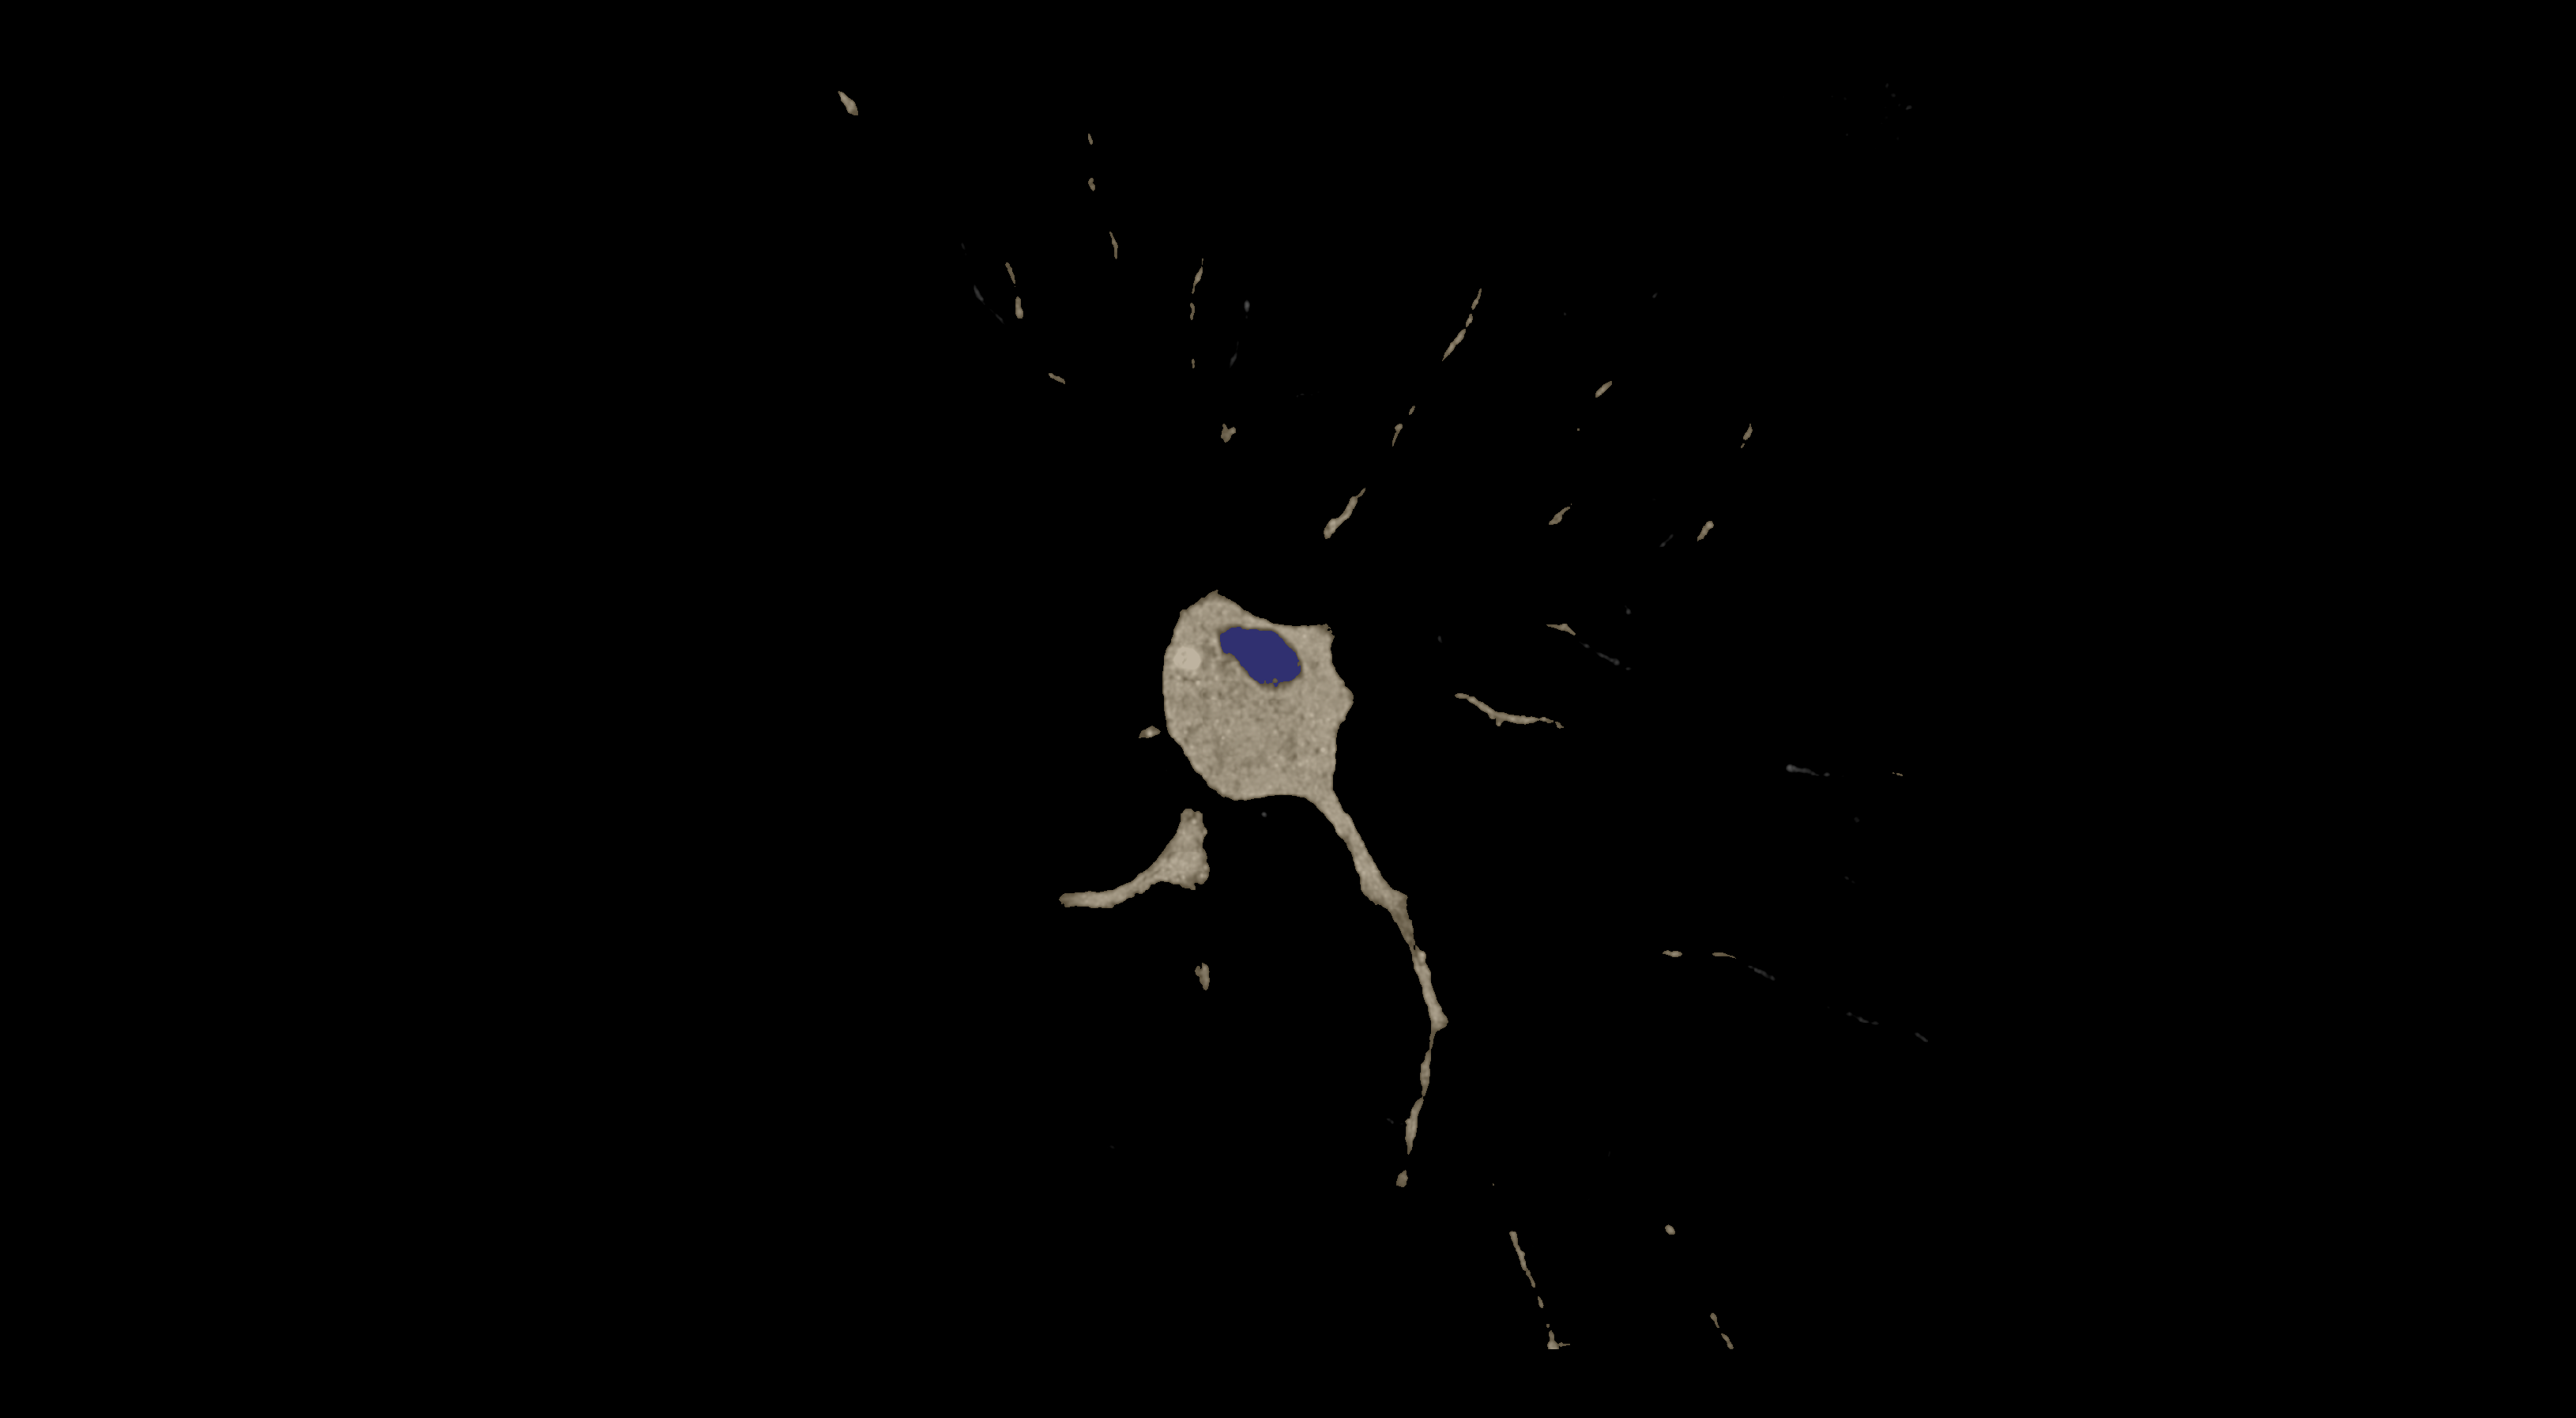

In [27]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [28]:
viewer.close()

-------------
## SUMMARY

The above details how the cytoplasm, nucleus, and cell masks are inferred.  

### NEXT: INFER {organelles}

proceed to any subsequent organelle notebook: 
* [04_infer_lysosome.ipynb](./04_infer_lysosome.ipynb)
* [05_infer_mitochondria.ipynb](./05_infer_mitochondria.ipynb)
* [06_infer_golgi.ipynb](./06_infer_golgi.ipynb)
* [07_infer_peroxisimes.ipynb](./07_infer_peroxisome.ipynb)
* [08_infer_ER.ipynb](./08_infer_ER.ipynb)
* [09_infer_lipid_droplet.ipynb](./09_infer_lipid_droplet.ipynb)